# Merger models of blue supergiants 


by [Earl Patrick Bellinger](https://earlbellinger.com)$^{1,2}$

$^1$_Max Planck Institute for Astrophysics, Garching, Germany_ \
$^2$_Stellar Astrophysics Centre, Aarhus, Denmark_

In [1]:
import os

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

from ipywidgets import interact, IntSlider

import seaborn as sns

In [2]:
# Set plotting style 
sns.set(style="ticks", palette="muted", 
        rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use('thinfig')

In [3]:
from mesagrid import Track, Grid

In [4]:
types = ['X', 'O', 'B', 'A', 'F', 'G', 'K', 'M']
spectrals = np.array([1e99, 30000, 10000, 7500, 6000, 5200, 3700, 2400])
rgbs = [(1, 1, 1), # X, temp class just for setting upper bound 
        (175/255, 201/255, 1),       # O
        (199/255, 216/255, 1),       # B
        (1,       244/255, 243/255), # A 
        (1,       229/255, 207/255), # F 
        (1,       217/255, 178/255), # G 
        (1,       199/255, 142/255), # K 
        (1,       166/255, 81/255)]  # M

In [5]:
track_Hshell = Track('work/grid_normal/M_17-os_0.335-Z_0.02/')
track_Hcore  = Track('work/grid_normal/M_17-os_0.7-Z_0.02/')
track_loop   = Track('work/grid_semi/M_17-os_0.11-Z_0.02-semi_100/')
track_merge  = Track('work/grid_merge/M_17-mc_0.3-mg_0-Ye_0.28-Z_0.02/')

In [299]:
R = 10**track_merge.history.log_R
mdl_merge = np.argmin((R - 35)**2)

R = 10**track_Hcore.history.log_R
mdl_Hcore = np.argmin((R - 35)**2)

R = 10**track_Hshell.history.log_R
mdl_Hshel = np.argmin((R - 35)**2)

mask = np.logical_and(track_loop.history.center_h1 < 0.0001, 
                      track_loop.history.center_he4 < 0.9)
R = 10**track_loop.history.log_R
mdl = np.argmin((R[mask] - 35)**2)
mdl_blue = np.where(mask)[0][mdl]

In [347]:
def plot_kippenhahn(track, xlim=None, xlabel='Age [Myr]', xm=np.linspace(0, 17, 10000), mdl=None):
    DF = track.history
    index = track.index
    profs = track.profiles
    
    ages = np.array([track.get_history(prof_num).star_age.values[0]/1e6 
                     for prof_num in index.profile_number])
    X, Y = np.meshgrid(xm, ages)
    Z = np.array([sp.interpolate.interp1d(p.mass, np.log10(p.brunt_N/(2*np.pi)), 
                                      fill_value=np.nan, bounds_error=0)(xm) 
              for p in profs])
    
    conv = np.array([sp.interpolate.interp1d(p.mass, p.brunt_N<0, 
                 fill_value=np.nan, bounds_error=0)(xm) 
              for p in profs])
    
    ppcnomin = np.array([np.min(p.mass[(p.pp+p.cno) > 1]) for p in profs])
    ppcnomax = np.array([np.max(p.mass[(p.pp+p.cno) > 1]) for p in profs])
    
    triamin = np.array([np.min(p.mass[(p.tri_alpha) > 1]) for p in profs])
    triamax = np.array([np.max(p.mass[(p.tri_alpha) > 1]) for p in profs])
    
    
    plt.figure(figsize=(7,6.5))
    
    norm = mpl.colors.Normalize(vmin=-6, vmax=0)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
    vmin = int(norm.vmin)
    vmax = int(norm.vmax)
    
    plt.contourf(Y, X, conv, levels=[0,1,2,3,4,5,6,7], vmin=-1, vmax=3, cmap='Greys', zorder=-99999)
    plt.contourf(Y, X, Z, levels=np.arange(-6, 1, 1), vmin=vmin, vmax=vmax, cmap='Greens', zorder=-99999)
     
    plt.gca().set_rasterization_zorder(-1)
    
    plt.fill_between(ages, ppcnomin, ppcnomax, hatch='\\\\', ec='k', fc='none', alpha=0.8, lw=0, zorder=-9999)
    plt.fill_between(ages, triamin,  triamax,  hatch='////', ec='k', fc='none', alpha=1,   lw=0, zorder=-9999)
    
    specidx = np.array([np.min(np.where(Teff > spectrals)) for Teff in 10**DF.log_Teff])
    for cidx in np.unique(specidx):
        idx = specidx == cidx
        for ii, x in enumerate(idx):
            if not x and ii+1<len(idx) and idx[ii+1]:
                idx[ii] = 1
        plt.plot(ages[idx], DF.star_mass[idx], c='w', lw=10, zorder=-999)
        plt.plot(ages[idx], DF.star_mass[idx], c=rgbs[cidx], lw=8, zorder=-99)
    
    radii = [[prof.mass[np.argmin((10**prof.logR - radius)**2)] 
              if radius<10**prof.logR[0] else np.nan 
              for prof in profs]
             for radius in [1, 10, 35]]#, 100]]
    for rad in radii:
        plt.plot(ages, rad, ls='-', c='k', lw=1, zorder=-99)
    
    if mdl is not None:
        #plt.axvline(track.get_history(mdl).star_age.values[0]/1e6, ls='--', c='gray')
        plt.plot(track.get_history(mdl).star_age.values[0]/1e6, 
                 track.get_history(mdl).star_mass.values[0]+1, marker='*', ms=20, c='k')
    
    plt.xlabel(xlabel)
    plt.ylabel(r'Fractional mass $\mathbf{m/M_\odot}$')
    plt.ylim([0, 20])
    plt.gca().set_yticks([0, 5, 10, 15])
    
    if xlim is not None:
        plt.xlim(xlim)
    
    cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',
                 boundaries=np.array(range(vmin, vmax+2, 1))-0.5,
                 ticks=np.array(range(vmin, vmax+1, 1)))
    cb.ax.minorticks_off()
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.151)

    #plt.show()

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/1128811694.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


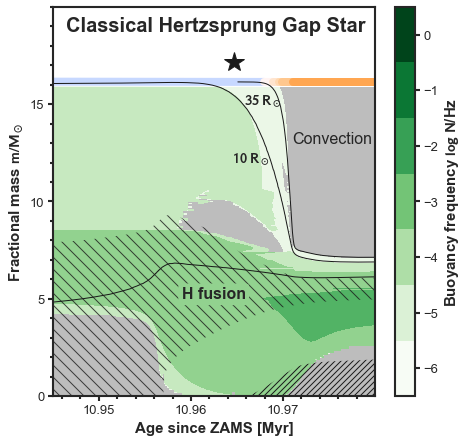

In [348]:
plot_kippenhahn(track_Hshell, 
                xlim=[10.945, 10.98], 
                xlabel='Age since ZAMS [Myr]', mdl=mdl_Hshel)

plt.text(0.97, 0.95, 'Classical Hertzsprung Gap Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)

plt.text(10.9645, 12, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(10.9658, 14.95, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)

plt.text(10.971, 13, 'Convection', size=16)

plt.gca().set_xticks([10.95, 10.96, 10.97])

plt.text(10.959, 5, 'H fusion', size=16, weight='bold',
    bbox=dict(facecolor='#92d28f', edgecolor='none', boxstyle='round,pad=0.2'))
plt.text(10.959, 5, 'H fusion', size=16, weight='bold',
    bbox=dict(facecolor='#92d28f', edgecolor='none', boxstyle='round,pad=0.2'))

plt.savefig('figs/kippenhahn_single.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/1128811694.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


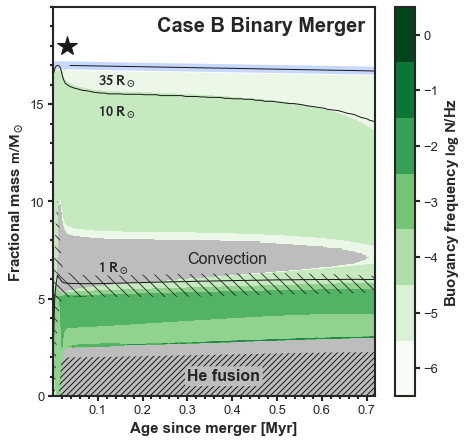

In [349]:
plot_kippenhahn(track_merge, xlabel='Age since merger [Myr]', mdl=mdl_merge)

plt.text(0.97, 0.95, 'Case B Binary Merger', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)
plt.text(0.1, 6.4, r'$\mathbf{1~R_\odot}$', weight='bold', size=14)
plt.text(0.1, 14.4, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(0.1, 16, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)

plt.text(0.3, 6.8, 'Convection', size=16)

plt.text(0.3, 0.8, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.0001'))
plt.text(0.3, 0.8, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.15'))

plt.savefig('figs/kippenhahn_merge.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/1128811694.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


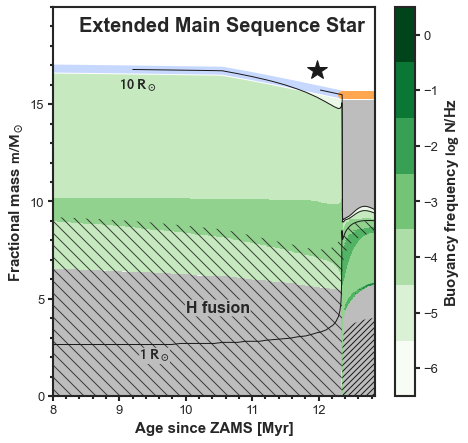

In [350]:
plot_kippenhahn(track_Hcore, xlabel='Age since ZAMS [Myr]', mdl=mdl_Hcore, xlim=[8, 12.85])

plt.text(0.97, 0.95, 'Extended Main Sequence Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)

plt.text(10, 4.3, 'H fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.05'))

plt.text(9.3, 1.9, r'$\mathbf{1~R_\odot}$', weight='bold', size=14,
        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.0001'))
plt.text(9, 15.8, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)

plt.savefig('figs/kippenhahn_extend.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/1128811694.py:68: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


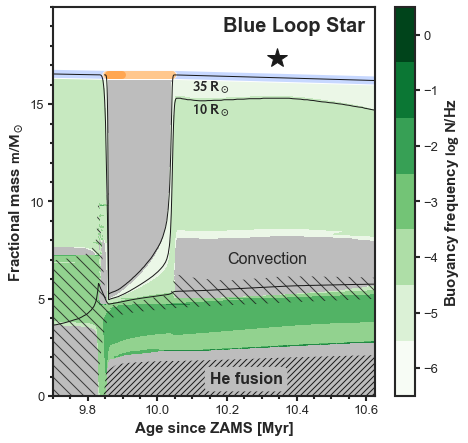

In [351]:
plot_kippenhahn(track_loop, xlabel='Age since ZAMS [Myr]', xlim=[9.7, 10.625], mdl=mdl_blue)

plt.text(0.97, 0.95, 'Blue Loop Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)

plt.text(10.1, 14.5, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(10.1, 15.7, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)

plt.text(10.2, 6.8, 'Convection', size=16)
plt.text(10.15, 0.65, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.3'))

plt.savefig('figs/kippenhahn_blueloop.pdf')

In [352]:
def plot_kippenhahn_r(track, xlim=None, xlabel='Age [Myr]', xs=10**np.linspace(-4, 0, 10000), mdl=None):
    DF = track.history
    index = track.index
    profs = track.profiles
    
    ages = np.array([track.get_history(prof_num).star_age.values[0]/1e6 
                     for prof_num in index.profile_number])
    X, Y = np.meshgrid(xs, ages)
    x = lambda p: 10**p.logR / 10**np.max(p.logR)
    Z = np.array([sp.interpolate.interp1d(x(p), np.log10(p.brunt_N/(2*np.pi)), 
                                      fill_value=np.log10(p.brunt_N/(2*np.pi)).values[-1], bounds_error=0)(xs) 
              for p in profs])
    
    conv = np.array([sp.interpolate.interp1d(x(p), p.brunt_N<0, 
                 fill_value=(p.brunt_N<0).values[-1], bounds_error=0)(xs) 
              for p in profs])
    
    ppcnomin = np.array([np.min(x(p)[(p.pp+p.cno) > 1]) for p in profs])
    ppcnomax = np.array([np.max(x(p)[(p.pp+p.cno) > 1]) for p in profs])
    
    triamin = np.array([np.min(x(p)[(p.tri_alpha) > 1]) for p in profs])
    triamax = np.array([np.max(x(p)[(p.tri_alpha) > 1]) for p in profs])
    
    for ii, p in enumerate(profs):
        ppcnomin[ii] = ppcnomin[ii] if ppcnomin[ii] > np.min(x(p)) else 0
        triamin [ii] = triamin [ii] if triamin [ii] > np.min(x(p)) else 0
    
    plt.figure(figsize=(7,6.5))
    
    norm = mpl.colors.Normalize(vmin=-6, vmax=0)
    cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greens)
    vmin = int(norm.vmin)
    vmax = int(norm.vmax)
    
    plt.contourf(Y, X, conv, levels=[0,1,2,3,4,5,6,7], vmin=-1, vmax=3, cmap='Greys', zorder=-99999)
    plt.contourf(Y, X, Z, levels=np.arange(-6, 1, 1), vmin=vmin, vmax=vmax, cmap='Greens', zorder=-99999)
     
    plt.gca().set_rasterization_zorder(-1)
    
    plt.fill_between(ages, ppcnomin, ppcnomax, hatch='\\\\', ec='k', fc='none', alpha=0.8, lw=0, zorder=-9999)
    plt.fill_between(ages, triamin,  triamax,  hatch='////', ec='k', fc='none', alpha=1,   lw=0, zorder=-9999)
    
    specidx = np.array([np.min(np.where(Teff > spectrals)) for Teff in 10**DF.log_Teff])
    for cidx in np.unique(specidx):
        idx = specidx == cidx
        for ii, x in enumerate(idx):
            if not x and ii+1<len(idx) and idx[ii+1]:
                idx[ii] = 1
        plt.plot(ages[idx], np.ones(len(ages[idx]))+0.2, c='w', lw=10, zorder=-999)
        plt.plot(ages[idx], np.ones(len(ages[idx]))+0.2, c=rgbs[cidx], lw=8, zorder=-99)
    
    #masses = [[10**prof.logR[np.argmin((prof.mass - mass)**2)] / 10**np.max(prof.logR) 
    #          for prof in profs]
    #         for mass in [1, 10, 15]]#, 100]]
    #for mass in masses:
    #    plt.plot(ages, mass, ls='-', c='k', lw=1, zorder=-99)
    
    radii = [[10**prof.logR[np.argmin((10**prof.logR - radius)**2)] / 10**np.max(prof.logR) 
              if radius<10**prof.logR[0] else np.nan 
              for prof in profs]
             for radius in [0.1, 1, 10, 35]]#, 100]]
    for rad in radii:
        plt.plot(ages, rad, ls='-', c='k', lw=1, zorder=-99)
    
    if mdl is not None:
        plt.plot(track.get_history(mdl).star_age.values[0]/1e6, 
                 1.8, marker='*', ms=20, c='k')
    
    plt.xlabel(xlabel)
    plt.ylabel(r'Fractional radius $\mathbf{r/R_\odot}$')
    plt.ylim([10**-4, 9])
    plt.semilogy()
    #plt.gca().set_yticks([0, 5, 10, 15])
    
    if xlim is not None:
        plt.xlim(xlim)
    
    cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',
                 boundaries=np.array(range(vmin, vmax+2, 1))-0.5,
                 ticks=np.array(range(vmin, vmax+1, 1)))
    cb.ax.minorticks_off()
    
    plt.tight_layout()

    #plt.show()

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/961578974.py:78: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


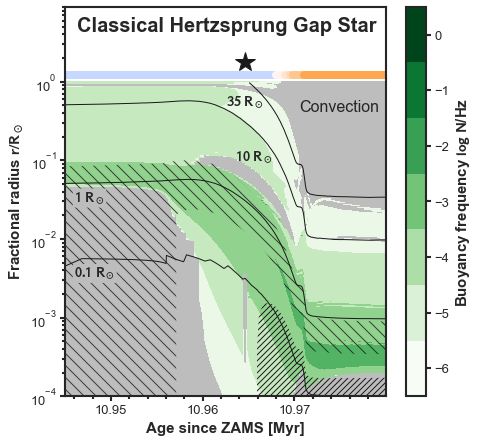

In [353]:
plot_kippenhahn_r(track_Hshell, 
                xlim=[10.945, 10.98], 
                xlabel='Age since ZAMS [Myr]', mdl=mdl_Hshel)

plt.text(0.97, 0.95, 'Classical Hertzsprung Gap Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)


plt.text(10.946, 3e-2, r'$\mathbf{1~R_\odot}$', weight='bold', size=14,
        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.1'))
plt.text(10.946, 3.3e-3, r'$\mathbf{0.1~R_\odot}$', weight='bold', size=14,
        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.1'))

plt.text(10.9635, 0.1, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(10.9625, 0.5, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)

plt.text(10.9705, 0.42, 'Convection', size=16)

plt.gca().set_xticks([10.95, 10.96, 10.97])

#plt.text(10.957, 0.025, 'H fusion', size=16, weight='bold',
#    bbox=dict(facecolor='#52b365', edgecolor='none', boxstyle='round,pad=0.001'), rotation=-30)
#plt.text(10.957, 0.025, 'H fusion', size=16, weight='bold',
#    bbox=dict(facecolor='#52b365', edgecolor='none', boxstyle='round,pad=0.15'), rotation=-30)

plt.savefig('figs/kippenhahn_single_r.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/961578974.py:78: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


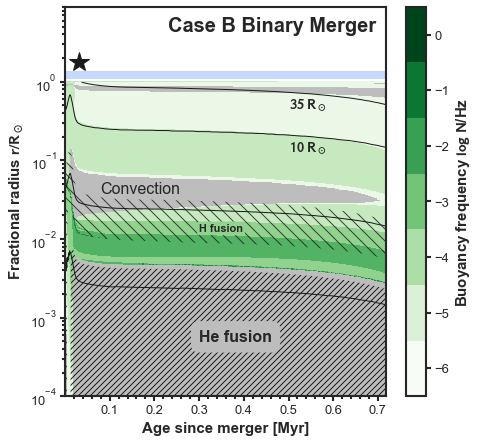

In [354]:
plot_kippenhahn_r(track_merge, xlabel='Age since merger [Myr]', mdl=mdl_merge)

plt.text(0.97, 0.95, 'Case B Binary Merger', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)
#plt.text(0.1, 6.4, r'$\mathbf{1~R_\odot}$', weight='bold', size=14)
#plt.text(0.1, 14.4, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
#plt.text(0.1, 16, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)

#plt.text(0.3, 6.8, 'Convection', size=16)

plt.text(0.3, 5e-4, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.5'))
plt.text(0.3, 5e-4, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.5'))

plt.text(0.3, 1.25e-2, 'H fusion', size=11, weight='bold',
    bbox=dict(facecolor='#92d28f', edgecolor='none', boxstyle='round,pad=0.15'))
plt.text(0.3, 1.25e-2, 'H fusion', size=11, weight='bold',
    bbox=dict(facecolor='#92d28f', edgecolor='none', boxstyle='round,pad=0.15'))

plt.text(0.08, 0.038, 'Convection', size=16)

plt.text(0.5, 0.13, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(0.5, 0.45, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)
#plt.text(0.5, 0.0013, r'$\mathbf{0.1~R_\odot}$', weight='bold', size=14,
#        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.1'))

plt.savefig('figs/kippenhahn_merge_r.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/961578974.py:78: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


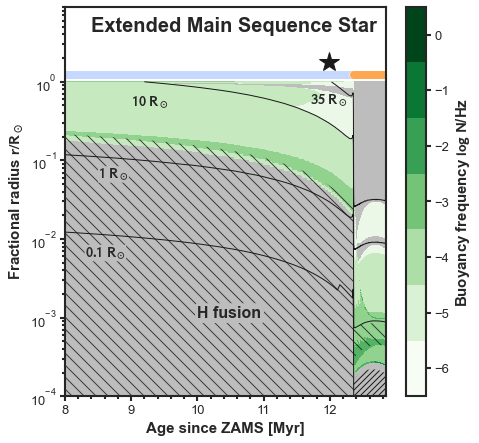

In [355]:
plot_kippenhahn_r(track_Hcore, xlabel='Age since ZAMS [Myr]', mdl=mdl_Hcore, xlim=[8, 12.85])

plt.text(0.97, 0.95, 'Extended Main Sequence Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)

plt.text(10, 0.001, 'H fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.15'))

plt.text(11.7, 0.53, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)
plt.text(9, 0.5, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(8.5, 0.06, r'$\mathbf{1~R_\odot}$', weight='bold', size=14,
        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.01'))
plt.text(8.3, 0.006, r'$\mathbf{0.1~R_\odot}$', weight='bold', size=14,
        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.01'))

plt.savefig('figs/kippenhahn_extend_r.pdf')

/afs/mpa/home/earl/.local/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_7920/961578974.py:78: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cb = plt.colorbar(cmap, label=r'Buoyancy frequency $\mathbf{log~N}$/Hz',


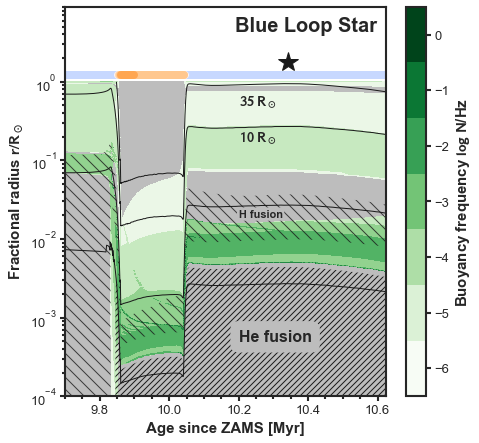

In [356]:
plot_kippenhahn_r(track_loop, xlabel='Age since ZAMS [Myr]', xlim=[9.7, 10.625], mdl=mdl_blue)

plt.text(0.97, 0.95, 'Blue Loop Star', weight='bold', size=20, #backgroundcolor='white',
             ha='right', va='center', transform=plt.gca().transAxes)

plt.text(10.2, 0.17, r'$\mathbf{10~R_\odot}$', weight='bold', size=14)
plt.text(10.2, 0.50, r'$\mathbf{35~R_\odot}$', weight='bold', size=14)
#plt.text(10.2, 0.0018, r'$\mathbf{0.1~R_\odot}$', weight='bold', size=14,
#        bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.00001'))

plt.text(10.2, 5e-4, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.5'))
plt.text(10.2, 5e-4, 'He fusion', size=16, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.5'))

plt.text(10.2, 1.9e-2, 'H fusion', size=11, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.01'))
plt.text(10.2, 1.9e-2, 'H fusion', size=11, weight='bold',
    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.15'))

#plt.text(10.2, 6.8, 'Convection', size=16)
#plt.text(10.15, 0.65, 'He fusion', size=16, weight='bold',
#    bbox=dict(facecolor='#bdbdbd', edgecolor='none', boxstyle='round,pad=0.15'))

plt.savefig('figs/kippenhahn_blueloop_r.pdf')